In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from IPython.display import Image
import scipy.stats as stats

from pgmpy.models import BayesianModel
from pgmpy.estimators import MaximumLikelihoodEstimator
from pgmpy.inference import VariableElimination

%matplotlib inline

In [2]:
data = pd.read_csv('../data/so.csv')

In [3]:
data = data[data.gender.isin(['Male', 'Female', 'Other'])]

In [4]:
data.gender.value_counts()

Male      51388
Female     3202
Other       274
Name: gender, dtype: int64

In [5]:
data.dogs_vs_cats.value_counts()

Dogs                      21852
Cats                      15508
Other (please specify)     7218
Name: dogs_vs_cats, dtype: int64

In [6]:
data.columns

Index([u'Unnamed: 0', u'collector', u'country', u'un_subregion', u'so_region',
       u'age_range', u'age_midpoint', u'gender', u'self_identification',
       u'occupation', u'occupation_group', u'experience_range',
       u'experience_midpoint', u'salary_range', u'salary_midpoint',
       u'big_mac_index', u'tech_do', u'tech_want', u'aliens',
       u'programming_ability', u'employment_status', u'industry',
       u'company_size_range', u'team_size_range', u'women_on_team', u'remote',
       u'job_satisfaction', u'job_discovery', u'dev_environment',
       u'commit_frequency', u'hobby', u'dogs_vs_cats', u'desktop_os',
       u'unit_testing', u'rep_range', u'visit_frequency',
       u'why_learn_new_tech', u'education', u'open_to_new_job',
       u'new_job_value', u'job_search_annoyance', u'interview_likelihood',
       u'how_to_improve_interview_process', u'star_wars_vs_star_trek',
       u'agree_tech', u'agree_notice', u'agree_problemsolving',
       u'agree_diversity', u'agree_adbloc

In [7]:
def df_to_cpd(df, target_var, parents=[],):
    variable_cardinality = df[target_var].nunique()
    if len(parents) == 0:
        values = [df[target_var].value_counts(normalize=True).values]
    else:
        df = df.dropna(subset=[target_var]+parents)
        evidence_card = [df[c].nunique() for c in parents]
        evidence = 1 #todo

In [8]:
model = BayesianModel([('gender', 'dogs_vs_cats'), ('age_midpoint', 'dogs_vs_cats')])
model.fit(data, estimator_type=MaximumLikelihoodEstimator, complete_samples_only=False)
infer = VariableElimination(model)
df = data

def ev(dictionary):
    return {k: list(df[k].unique()).index(v) for k,v in dictionary.items()}


In [9]:
print(infer.query(['dogs_vs_cats'], evidence=ev({'gender':'Male'}))['dogs_vs_cats'])

+----------------+---------------------+
| dogs_vs_cats   |   phi(dogs_vs_cats) |
|----------------+---------------------|
| dogs_vs_cats_0 |              0.3924 |
| dogs_vs_cats_1 |              0.4143 |
| dogs_vs_cats_2 |              0.1933 |
+----------------+---------------------+


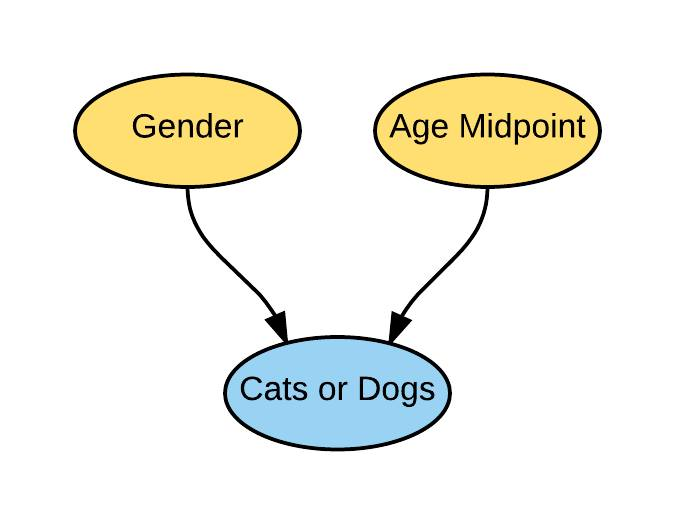

In [10]:
Image('../figures/catdog.png')

Picca voor *M. Bueno*

In [11]:
df_ = df.dropna(subset=['salary_range'])
df_ = df_[df_['salary_range'].str.contains('\$')]
df_['desktop_os'] = df_['desktop_os'].str.replace('Ubuntu|Debian|Fedora|Mint|Other Linux', 'Linux')
df_['desktop_os'] = df_['desktop_os'].str.replace('Windows.*', 'Windows')
df_['is_javascript'] = df_['tech_do'].str.contains('JavaScript')
df_['is_php'] = df_['tech_do'].str.contains('PHP')
df_['is_python'] = df_['tech_do'].str.contains('Python')
df_['salary_range'] = df_.salary_range.str.replace('\$[0-9]{3},000 - \$[0-9]{3},000', 'More than $100,000')
df_['salary_range'] = df_.salary_range.str.replace('More than \$200,000', 'More than $100,000')

In [12]:
model = BayesianModel([('age_range', 'star_wars_vs_star_trek'), 
                       ('age_range', 'experience_range'),
                       ('experience_range', 'salary_range'),
                       ('gender', 'salary_range'),
                       ('un_subregion', 'salary_range'),
                       ('gender', 'agree_diversity'),
                       ('agree_diversity', 'is_javascript'),
                       ('agree_diversity', 'is_php'),
                       ('agree_diversity', 'is_python'),
                       ('un_subregion', 'desktop_os'),
                       ('desktop_os', 'is_javascript'),
                       ('desktop_os', 'is_php'),
                       ('desktop_os', 'is_python'),
                       ('is_javascript', 'salary_range'),
                       ('is_php', 'salary_range'),
                       ('is_python', 'salary_range'),
                       ('age_range', 'desktop_os'),
                       ('un_subregion', 'agree_diversity'),])
model.fit(df_, estimator_type=MaximumLikelihoodEstimator, complete_samples_only=False)

In [13]:
with open('cpds.txt', 'w') as out:
    for cpd in model.get_cpds():
        out.write(str(cpd) + '\n')

In [14]:
df_['salary_range']

1         $40,000 - $50,000
3         Less than $10,000
6        More than $100,000
7         Less than $10,000
9         Less than $10,000
11        $10,000 - $20,000
12        Less than $10,000
13        Less than $10,000
14        $10,000 - $20,000
19        $10,000 - $20,000
20       $90,000 - $100,000
21        Less than $10,000
23        Less than $10,000
26        $40,000 - $50,000
28        $30,000 - $40,000
32        $10,000 - $20,000
33        $30,000 - $40,000
34        $10,000 - $20,000
35        Less than $10,000
36        $10,000 - $20,000
37        $20,000 - $30,000
38        $10,000 - $20,000
39        $10,000 - $20,000
40        $10,000 - $20,000
41        Less than $10,000
42        $70,000 - $80,000
45       $90,000 - $100,000
46        $20,000 - $30,000
47       More than $100,000
48        $30,000 - $40,000
                ...        
55987    More than $100,000
55988    More than $100,000
55989     $80,000 - $90,000
55990    More than $100,000
55991    More than $

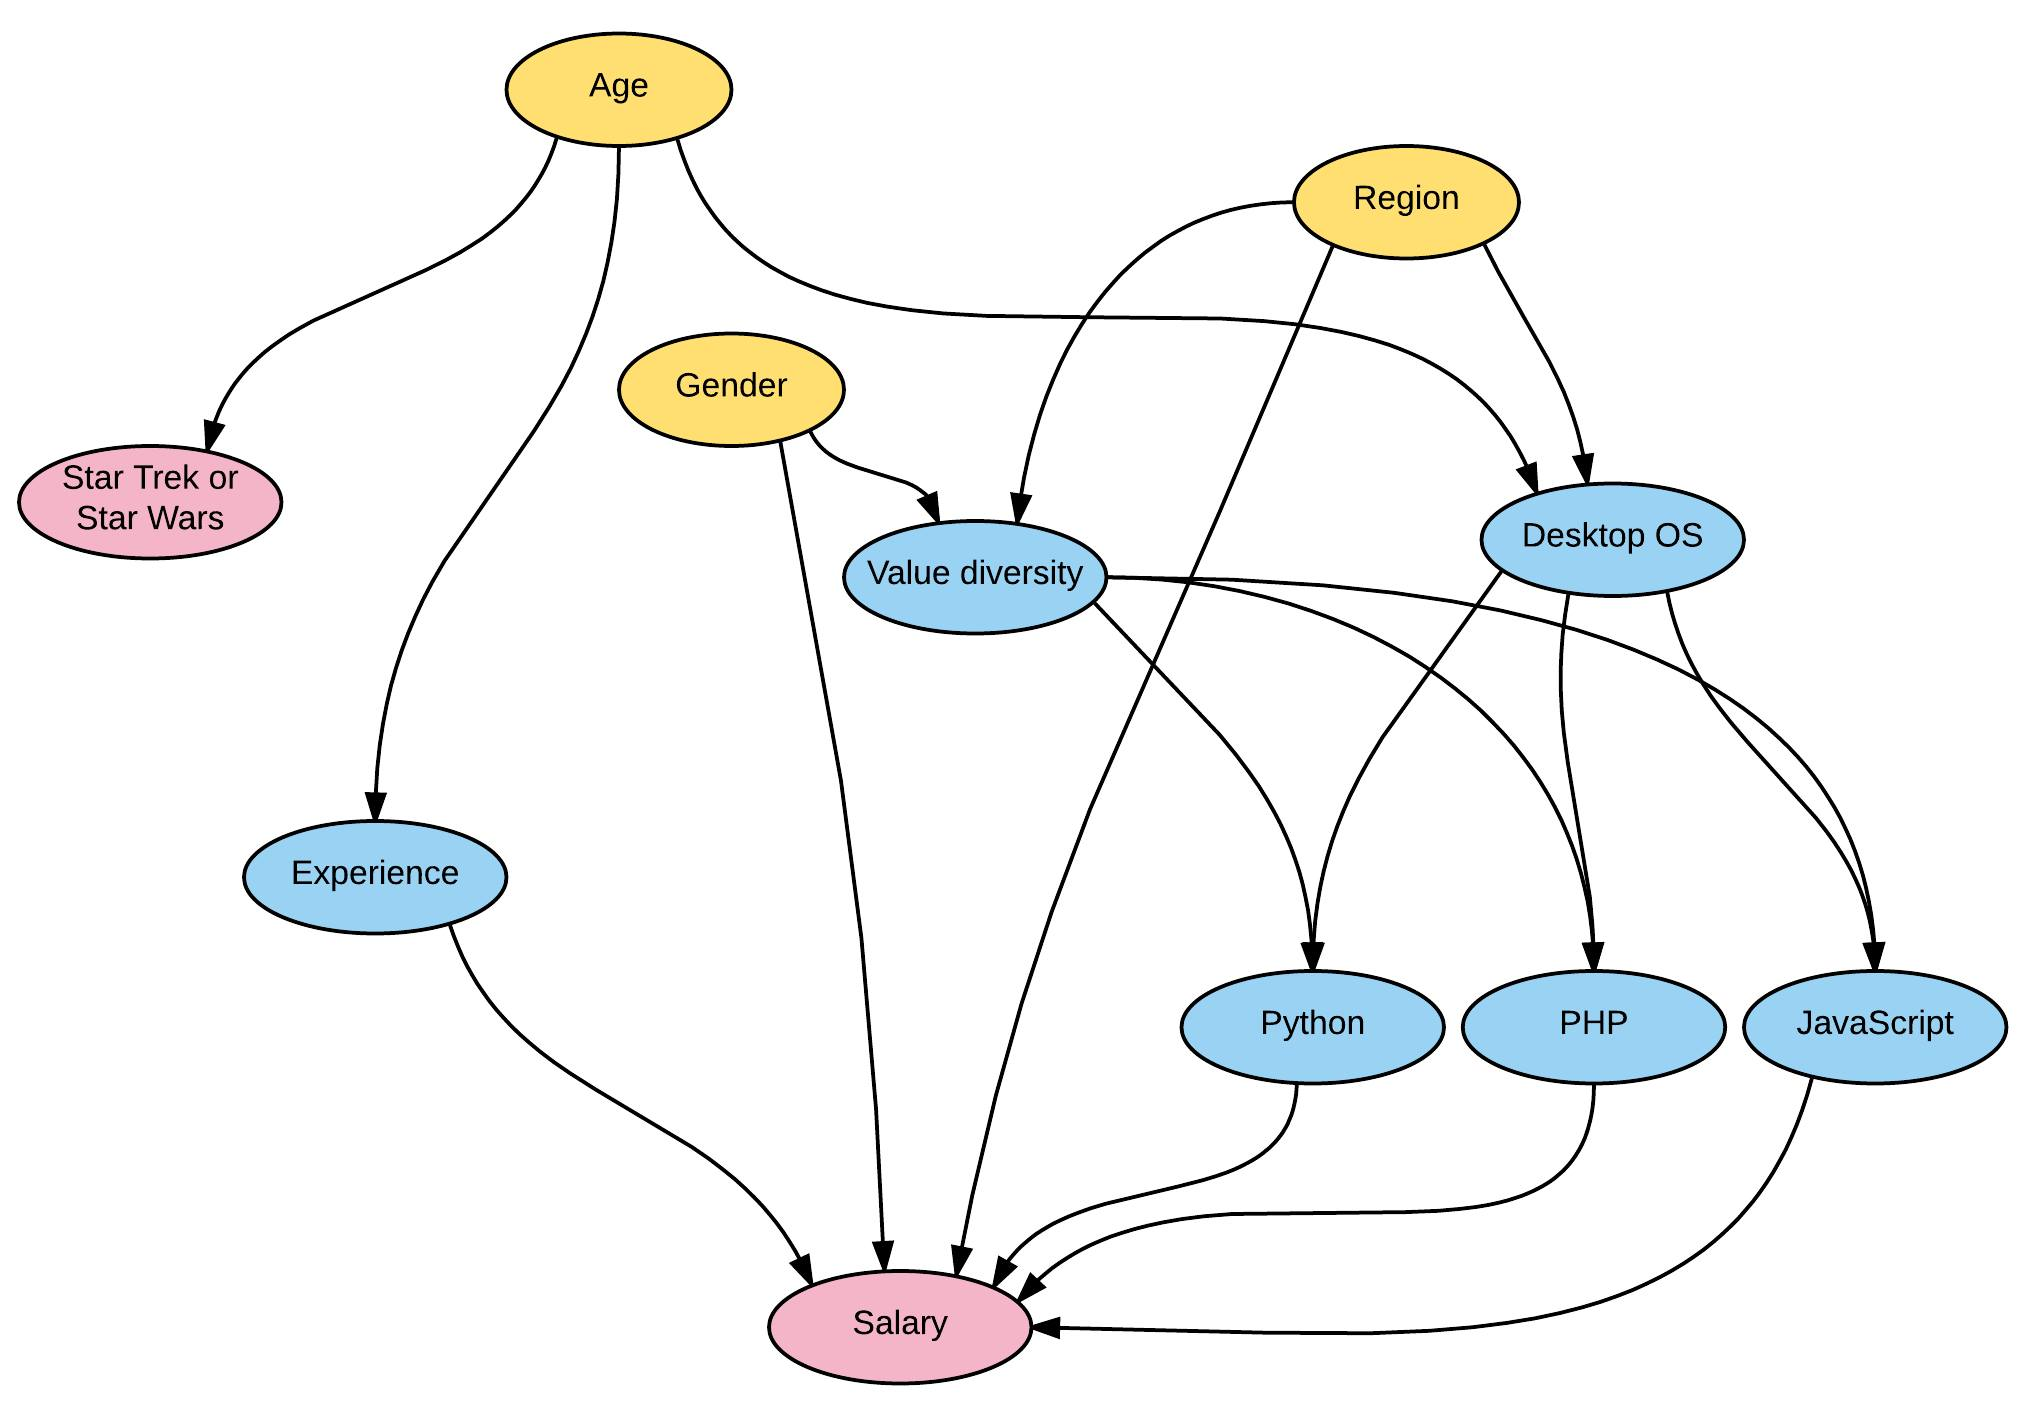

In [15]:
Image('../figures/network1.png')

In [18]:
data = df_[['age_range', 'star_wars_vs_star_trek', 'experience_range', 
            'salary_range', 'gender', 'un_subregion', 'agree_diversity',
            'is_javascript', 'is_php', 'is_python', 'desktop_os', 'age_midpoint', 
            'salary_midpoint', 'experience_midpoint']]

In [19]:
likert = ['Disagree completely', 'Disagree somewhat', 'Neutral', 'Agree somewhat', 'Agree completely']
data['agree_diversity'] = data['agree_diversity'].apply(lambda x: likert.index(x) + 1 if x in likert else np.nan)
print(data['agree_diversity'].head())

1        4.0
3        4.0
6        NaN
7        1.0
9        4.0
11       4.0
12       5.0
13       5.0
14       5.0
19       5.0
20       3.0
21       4.0
23       4.0
26       5.0
28       NaN
32       5.0
33       5.0
34       4.0
35       5.0
36       5.0
37       3.0
38       4.0
39       4.0
40       4.0
41       4.0
42       4.0
45       4.0
46       1.0
47       5.0
48       3.0
        ... 
55987    3.0
55988    5.0
55989    NaN
55990    5.0
55991    5.0
55992    5.0
55993    3.0
55994    5.0
55996    4.0
55997    5.0
55998    4.0
55999    3.0
56000    4.0
56001    5.0
56002    5.0
56003    4.0
56004    5.0
56005    3.0
56006    5.0
56007    4.0
56008    5.0
56009    4.0
56011    NaN
56016    NaN
56017    NaN
56019    4.0
56022    4.0
56024    NaN
56026    NaN
56029    3.0
Name: agree_diversity, dtype: float64


C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [74]:
sb.set(font_scale=1.5)
def correlation(data, x, y, xname, yname):
    d = data.dropna(subset=[x, y])
    print('correlation {} with {}'.format(x, y))
    print('r=%.2f, p=%.20f' % stats.pearsonr(d[x], d[y]))
    plt.figure(figsize=(10, 10))
    
    
    font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}
    
    ax = sb.violinplot(d[x], d[y], xlabel=xname)
    ax.set(xlabel=xname, ylabel=yname)
    
    plt.show()

correlation age_midpoint with experience_midpoint
r=0.68, p=0.00000000000000000000


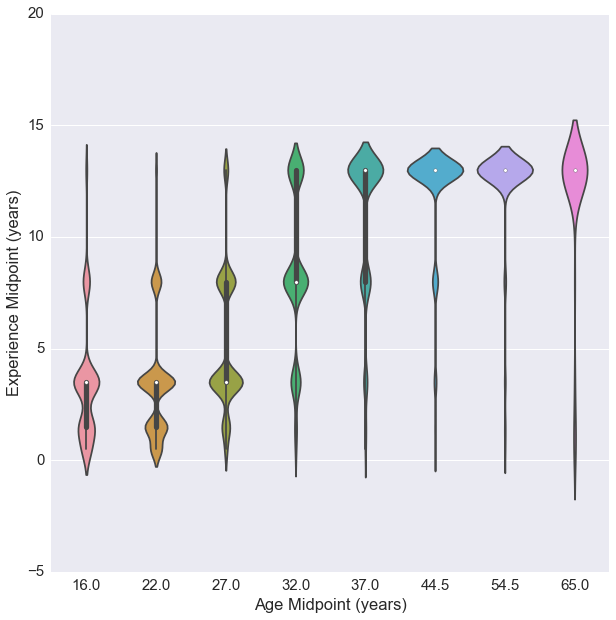

correlation experience_midpoint with salary_midpoint
r=0.49, p=0.00000000000000000000


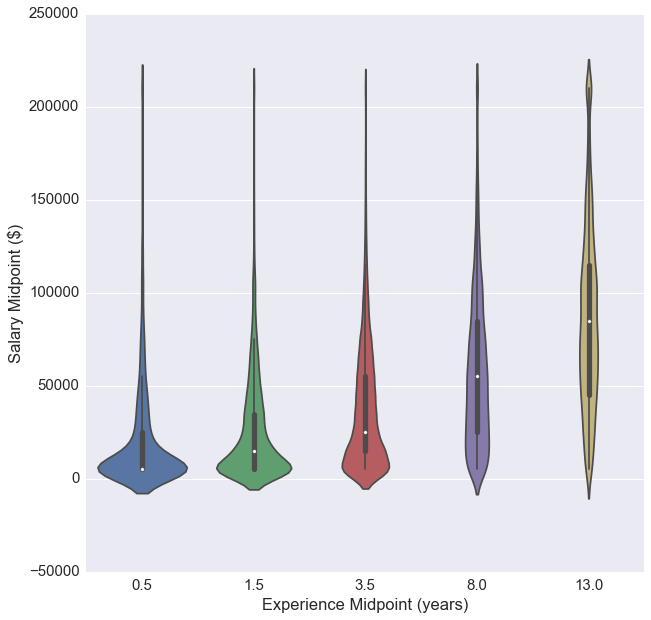

In [75]:
correlation(data, 'age_midpoint', 'experience_midpoint', 'Age Midpoint (years)', 'Experience Midpoint (years)')
correlation(data, 'experience_midpoint', 'salary_midpoint', 'Experience Midpoint (years)', 'Salary Midpoint ($)')

In [33]:
stats.ttest_ind(data.age_midpoint[data.star_wars_vs_star_trek == 'Star Wars'].dropna(), data.age_midpoint[data.star_wars_vs_star_trek == 'Star Trek'].dropna())

Ttest_indResult(statistic=-38.465081646314331, pvalue=0.0)

In [34]:
def test_median(data, x, y, normal=True, plots=False):
    d = data.dropna(subset=[x, y])
    groups = [d[y][d[x] == u] for u in d[x].unique()]
    if plots:
        for group in groups:
            plt.figure()
            plt.hist(group)
            plt.show()
    if normal:
        F, p = stats.f_oneway(*groups)
    else:
        F, p = stats.kruskal(*groups)
    print("{} with {}".format(x, y))
    print('p=%.4f' % p)

In [35]:
test_median(data, 'un_subregion', 'agree_diversity', normal=False)

un_subregion with agree_diversity
p=0.0000


In [36]:
test_median(data, 'un_subregion', 'age_midpoint')

un_subregion with age_midpoint
p=0.0000


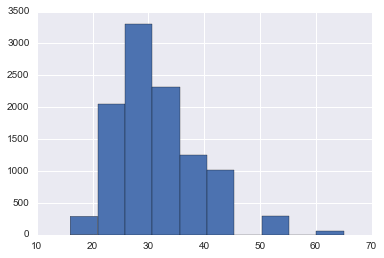

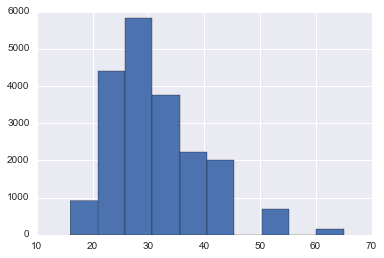

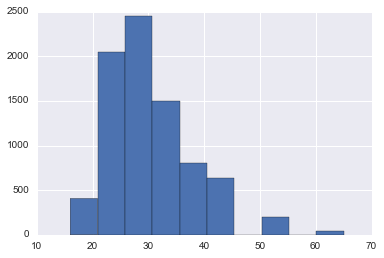

desktop_os with age_midpoint
p=0.0000


In [37]:
test_median(data, 'desktop_os', 'age_midpoint', plots=True)

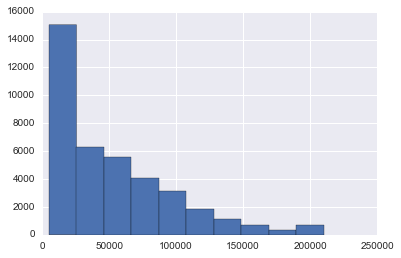

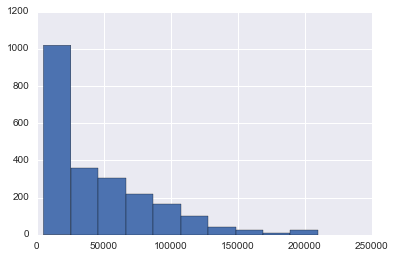

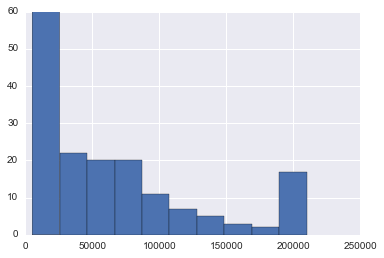

gender with salary_midpoint
p=0.0000


In [38]:
test_median(data, 'gender', 'salary_midpoint', normal=False, plots=True)

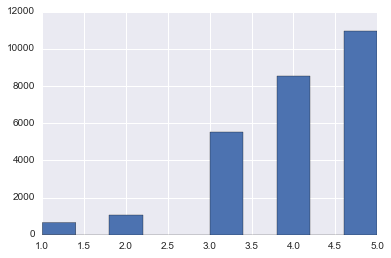

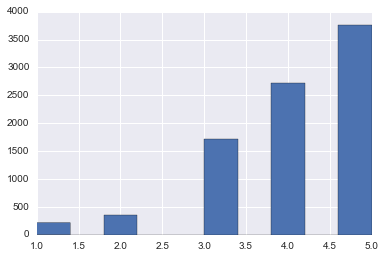

is_python with agree_diversity
p=0.0030


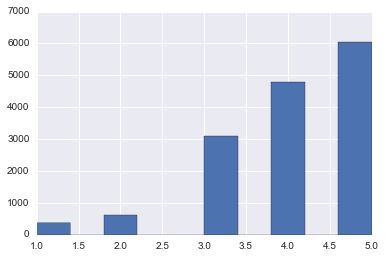

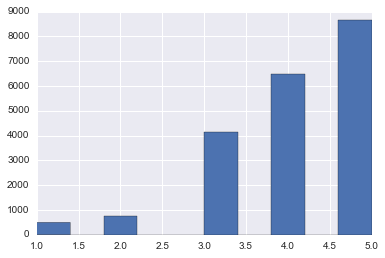

is_javascript with agree_diversity
p=0.0009


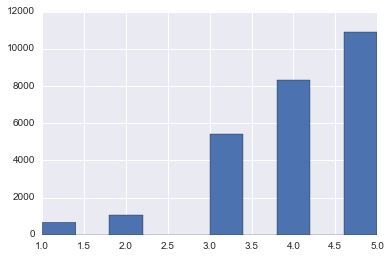

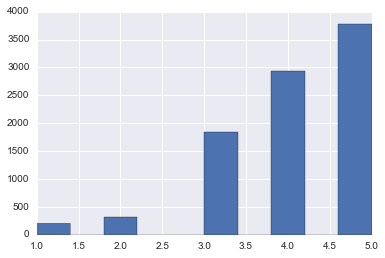

is_php with agree_diversity
p=0.1297


In [39]:
test_median(data, 'is_python', 'agree_diversity', normal=False, plots=True)
test_median(data, 'is_javascript', 'agree_diversity', normal=False, plots=True)
test_median(data, 'is_php', 'agree_diversity', normal=False, plots=True)

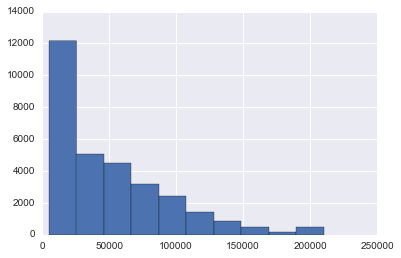

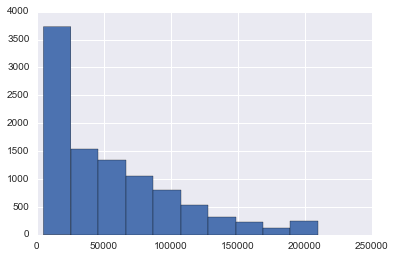

is_python with salary_midpoint
p=0.0000


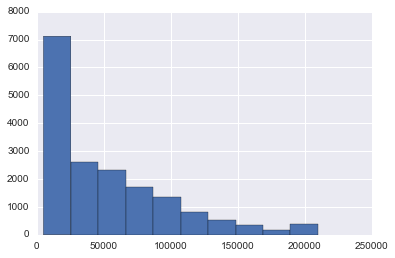

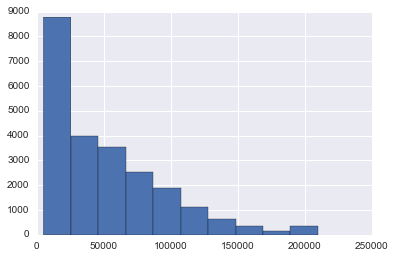

is_javascript with salary_midpoint
p=0.0002


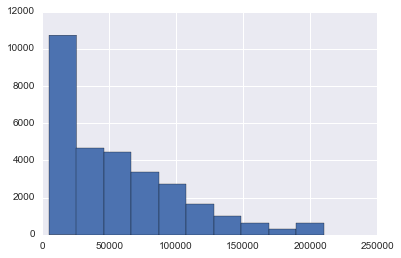

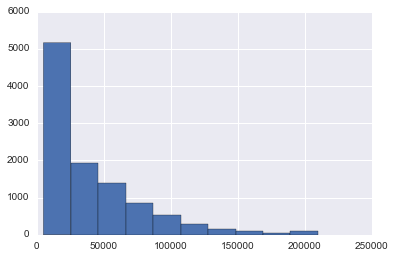

is_php with salary_midpoint
p=0.0000


In [40]:
test_median(data, 'is_python', 'salary_midpoint', normal=False, plots=True)
test_median(data, 'is_javascript', 'salary_midpoint', normal=False, plots=True)
test_median(data, 'is_php', 'salary_midpoint', normal=False, plots=True)

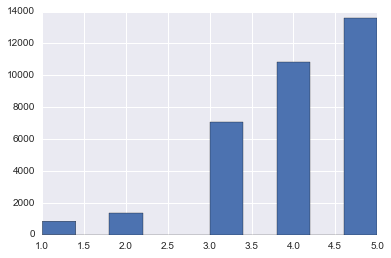

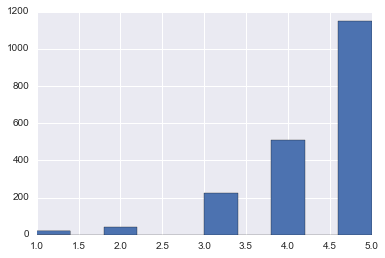

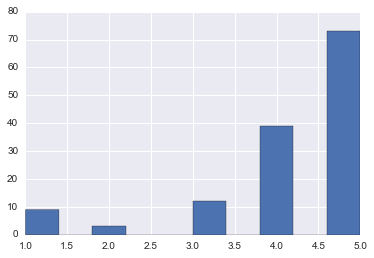

gender with agree_diversity
p=0.0000


In [41]:
test_median(data, 'gender', 'agree_diversity', normal=False, plots=True)

In [100]:
def chisquare(data, x, y):
    d = data.dropna(subset=[x, y])
    for value in d[x].unique():
        chisq, p = stats.chisquare(d[y][d[x] == value].value_counts().values, d[y].value_counts().values)
        print(d[y][d[x] == value].value_counts(normalize=True))
        print('{}={}: p={}'.format(x, value, p))

In [101]:
chisquare(data, 'is_python', 'desktop_os')
chisquare(data, 'is_javascript', 'desktop_os')
chisquare(data, 'is_php', 'desktop_os')
print(data['desktop_os'].value_counts(normalize=True))

Windows     0.571399
Mac OS X    0.267413
Linux       0.161188
Name: desktop_os, dtype: float64
is_python=False: p=0.0
Linux       0.359141
Windows     0.342976
Mac OS X    0.297884
Name: desktop_os, dtype: float64
is_python=True: p=0.0
Windows     0.507911
Mac OS X    0.255002
Linux       0.237087
Name: desktop_os, dtype: float64
is_javascript=False: p=0.0
Windows     0.520847
Mac OS X    0.289511
Linux       0.189642
Name: desktop_os, dtype: float64
is_javascript=True: p=0.0
Windows     0.532785
Mac OS X    0.268256
Linux       0.198959
Name: desktop_os, dtype: float64
is_php=False: p=0.0
Windows     0.465264
Mac OS X    0.293963
Linux       0.240773
Name: desktop_os, dtype: float64
is_php=True: p=0.0
Windows     0.516879
Mac OS X    0.273731
Linux       0.209389
Name: desktop_os, dtype: float64


In [79]:
data.is_python

1        False
3          NaN
6         True
7        False
9        False
11       False
12       False
13       False
14        True
19        True
20       False
21       False
23       False
26         NaN
28       False
32       False
33        True
34        True
35       False
36       False
37       False
38       False
39       False
40       False
41       False
42       False
45       False
46       False
47       False
48       False
         ...  
55987     True
55988    False
55989    False
55990     True
55991    False
55992     True
55993    False
55994    False
55996    False
55997    False
55998    False
55999     True
56000    False
56001    False
56002    False
56003    False
56004    False
56005    False
56006    False
56007     True
56008    False
56009    False
56011     True
56016    False
56017    False
56019     True
56022    False
56024    False
56026     True
56029    False
Name: is_python, dtype: object

In [80]:
data.desktop_os

1        Mac OS X
3           Linux
6         Windows
7         Windows
9         Windows
11        Windows
12        Windows
13       Mac OS X
14        Windows
19          Linux
20        Windows
21       Mac OS X
23       Mac OS X
26        Windows
28        Windows
32          Linux
33          Linux
34          Linux
35        Windows
36          Linux
37        Windows
38          Linux
39          Linux
40          Linux
41          Linux
42       Mac OS X
45          Linux
46        Windows
47          Linux
48        Windows
           ...   
55987       Linux
55988    Mac OS X
55989    Mac OS X
55990    Mac OS X
55991    Mac OS X
55992       Linux
55993    Mac OS X
55994     Windows
55996     Windows
55997     Windows
55998     Windows
55999    Mac OS X
56000     Windows
56001    Mac OS X
56002    Mac OS X
56003     Windows
56004    Mac OS X
56005    Mac OS X
56006       Linux
56007       Linux
56008       Linux
56009    Mac OS X
56011       Linux
56016         NaN
56017    M